### init

In [1]:
pip install numpy pandas matplotlib scipy dtaidistance scikit-learn pydmd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.9/148.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 47.0 MB/s eta 0:00:00


In [2]:
import requests

API_KEY = "92a2e9e4dd264b5d93de7b048fc743cf"
SYMBOL = "btc/usd"
START_DATE = "2025-02-18 05:30:00"
END_DATE = "2025-02-22 05:30:00"
INTERVAL = "15min"
TIMEZONE = "Asia/Kolkata"

url = f"https://api.twelvedata.com/time_series?symbol={SYMBOL}&interval={INTERVAL}&start_date={START_DATE}&end_date={END_DATE}&timezone={TIMEZONE}&apikey={API_KEY}"

response = requests.get(url)
data = response.json()
poly1d = [];
if "values" in data:
    p1 = [{"close": float(item["close"]), "time": item["datetime"]} for item in data["values"]]
    print(len(p1))
else:
    print("Error:", data)


385


In [3]:
API_KEY = "92a2e9e4dd264b5d93de7b048fc743cf"
SYMBOL = "usd/jpy"
START_DATE = "2021-01-11 05:30:00"
END_DATE = "2021-01-15 05:30:00"
INTERVAL = "15min"
TIMEZONE = "Asia/Kolkata"

url = f"https://api.twelvedata.com/time_series?symbol={SYMBOL}&interval={INTERVAL}&start_date={START_DATE}&end_date={END_DATE}&timezone={TIMEZONE}&apikey={API_KEY}"

response = requests.get(url)
data = response.json()
p2 = [];
if "values" in data:
    p2 = [{"close": float(item["close"]), "time": item["datetime"]} for item in data["values"]]
    print(len(p2))
else:
    print("Error:", data)

385


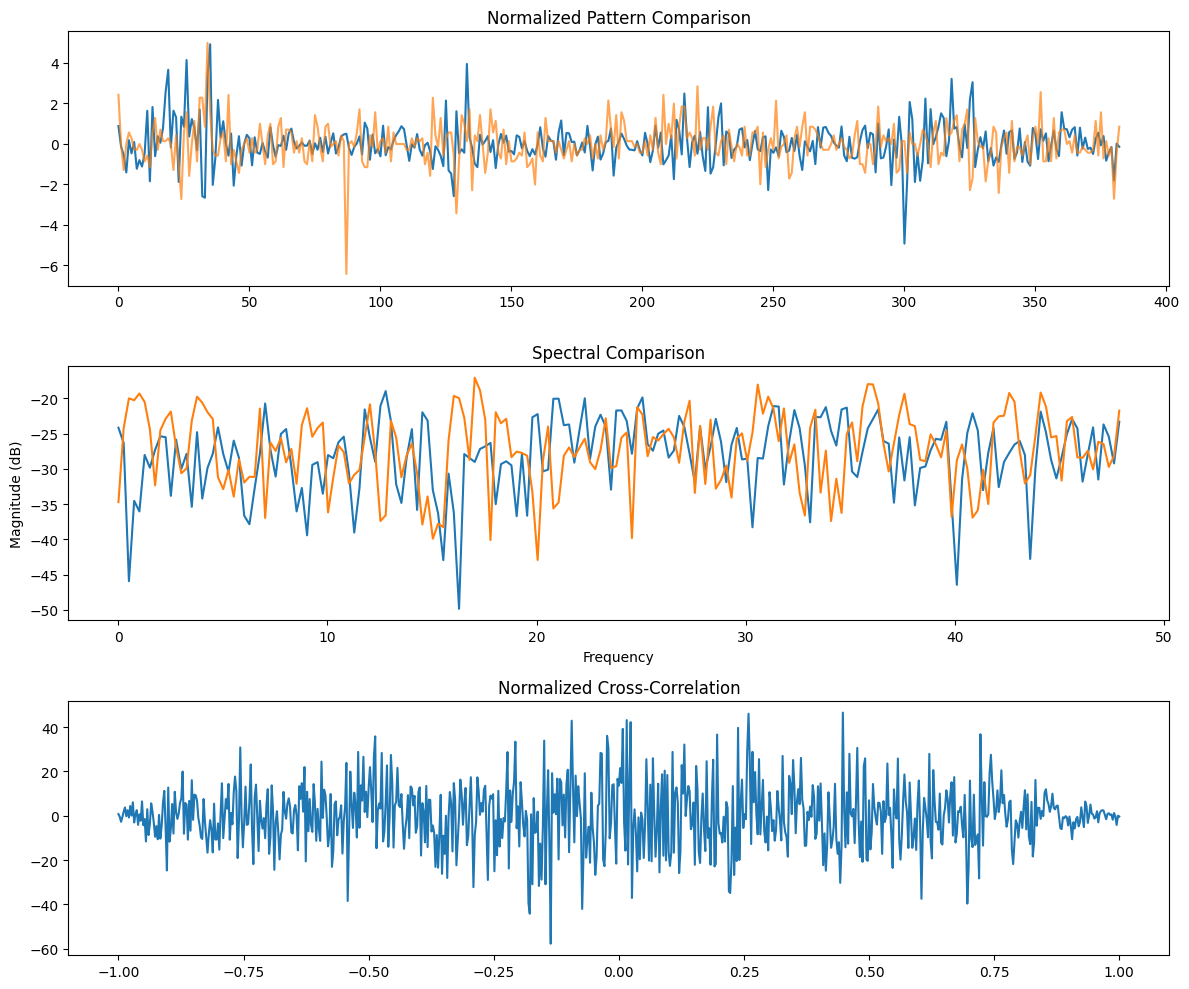


--- Pattern Similarity Report ---
1. Dynamic Similarity Score: 0.345
2. Spectral Cosine Similarity: 0.784
3. Statistical Significance (p-value): 0.0330

Conclusion: No significant similarity detected


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import correlate, coherence, stft
from dtaidistance import dtw
from sklearn.feature_selection import mutual_info_regression
from pydmd import DMD
from scipy.spatial.distance import cosine

# ----------------------------------------
# 1. Data Preparation (Time-Agnostic)
# ----------------------------------------
def prepare_pattern(data, expected_length=384):
    """Convert raw data to normalized pattern without time alignment"""
    closes = [x['close'] for x in data]

    # Handle variable lengths
    if len(closes) < expected_length:
        closes += [closes[-1]] * (expected_length - len(closes))
    else:
        closes = closes[:expected_length]

    # Convert to stationary series
    returns = np.diff(np.log(closes))
    return (returns - np.mean(returns)) / np.std(returns)

# Load your data
btc_data = p1  # Your BTC data (list of dicts)
x_data = p2     # Your stock data

# Create comparable patterns
btc_pattern = prepare_pattern(btc_data)
x_pattern = prepare_pattern(x_data)

# ----------------------------------------
# 2. Advanced Similarity Metrics
# ----------------------------------------
def spectral_cos_sim(a, b):
    """Frequency-domain similarity using FFT"""
    fft_a = np.abs(np.fft.rfft(a))
    fft_b = np.abs(np.fft.rfft(b))
    return 1 - cosine(fft_a, fft_b)

def dynamic_similarity(a, b):
    """Combined time-frequency similarity"""
    # Dynamic Time Warping
    dtw_dist = dtw.distance(a, b)

    # Fourier coherence
    f, Cxy = coherence(a, b, fs=4*24)  # 15-min data

    # Mutual information
    mi = mutual_info_regression(a.reshape(-1, 1), b)

    return 0.5*(1/(1+dtw_dist)) + 0.3*np.mean(Cxy) + 0.2*mi[0]

def state_space_similarity(a, b):
    """DMD-based pattern matching"""
    dmd = DMD(svd_rank=5)
    dmd.fit(np.vstack([a, b]))
    return np.exp(-np.linalg.norm(dmd.modes[:,0] - dmd.modes[:,1]))

# ----------------------------------------
# 3. Comprehensive Similarity Analysis
# ----------------------------------------
metrics = {
    'DTW Distance': 1/(1 + dtw.distance(btc_pattern, x_pattern)),
    'Spectral Cosine': spectral_cos_sim(btc_pattern, x_pattern),
    'Dynamic Similarity': dynamic_similarity(btc_pattern, x_pattern),
    'State Space': state_space_similarity(btc_pattern, x_pattern),
    'Cross-Correlation': np.max(correlate(btc_pattern, x_pattern))/len(btc_pattern)
}

# ----------------------------------------
# 4. Statistical Validation
# ----------------------------------------
def permutation_test(true_score, pattern_a, n_iter=1000):
    """Test significance against random permutations"""
    null_scores = []
    for _ in range(n_iter):
        shuffled = np.random.permutation(pattern_a.copy())
        null_scores.append(dynamic_similarity(shuffled, btc_pattern))
    return np.mean(true_score < null_scores)

p_value = permutation_test(metrics['Dynamic Similarity'], x_pattern)

# ----------------------------------------
# 5. Visualization
# ----------------------------------------
fig, ax = plt.subplots(3, 1, figsize=(12, 10))

# Time Domain
ax[0].plot(btc_pattern, label='BTC Pattern')
ax[0].plot(x_pattern, label='Stock Pattern', alpha=0.7)
ax[0].set_title("Normalized Pattern Comparison")

# Frequency Domain
ax[1].magnitude_spectrum(btc_pattern, Fs=4*24, label='BTC', scale='dB')
ax[1].magnitude_spectrum(x_pattern, Fs=4*24, label='Stock', scale='dB')
ax[1].set_title("Spectral Comparison")

# Cross-Correlation
correlation = correlate(btc_pattern, x_pattern, mode='full')
ax[2].plot(np.linspace(-1, 1, len(correlation)), correlation)
ax[2].set_title("Normalized Cross-Correlation")

plt.tight_layout()
plt.show()

# ----------------------------------------
# 6. Results Interpretation
# ----------------------------------------
print("\n--- Pattern Similarity Report ---")
print(f"1. Dynamic Similarity Score: {metrics['Dynamic Similarity']:.3f}")
print(f"2. Spectral Cosine Similarity: {metrics['Spectral Cosine']:.3f}")
print(f"3. Statistical Significance (p-value): {p_value:.4f}")

if metrics['Dynamic Similarity'] > 0.75 and p_value < 0.05:
    print("\nConclusion: Strong evidence of structural similarity")
elif metrics['Dynamic Similarity'] > 0.6 and p_value < 0.1:
    print("\nConclusion: Moderate pattern similarity")
else:
    print("\nConclusion: No significant similarity detected")

In [5]:
pip install statsmodels PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 91.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 92.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 18.5 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/loc

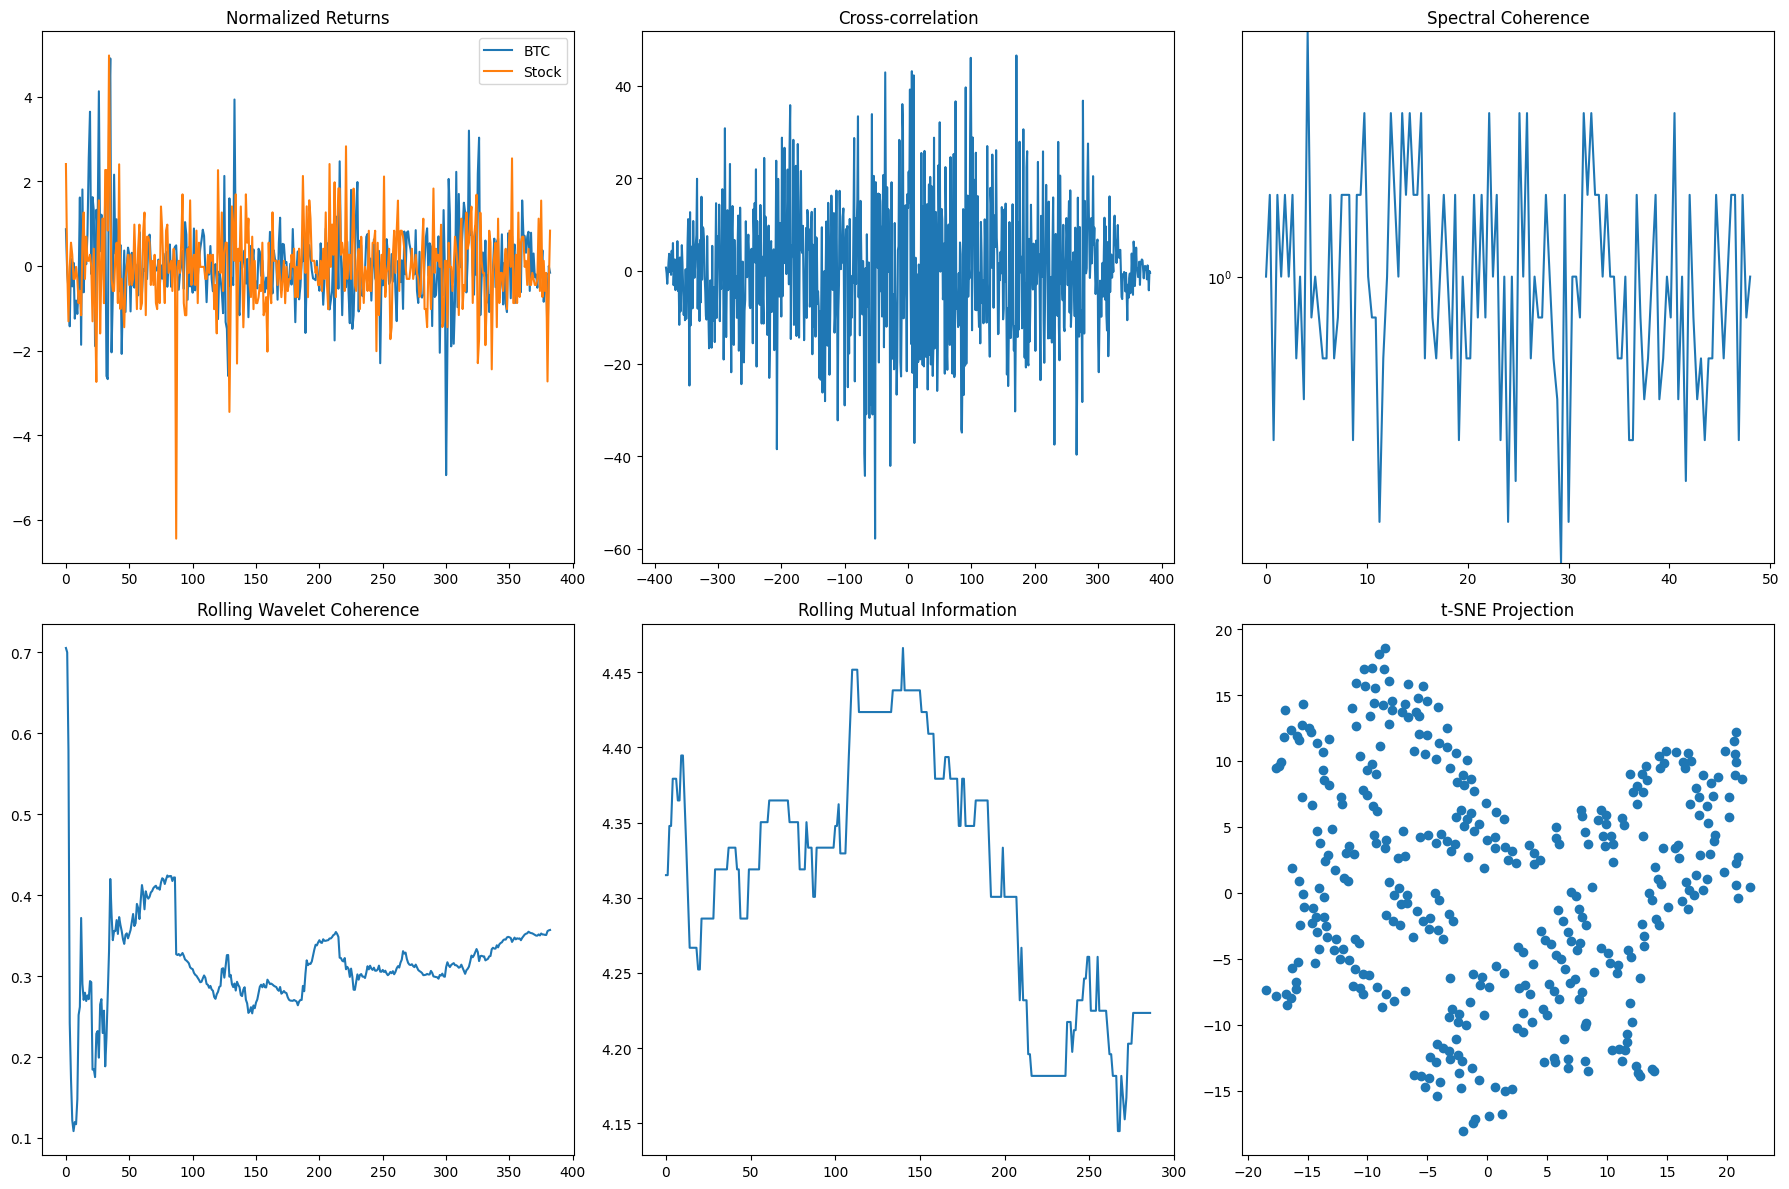


    === Pattern Analysis Results ===
    1. Dynamic Time Warping: 0.063
    2. Pearson Correlation: 0.035
    3. Spectral Coherence: 1.000
    4. Wavelet Coherence: 0.357
    5. Mutual Information: 0.061
    6. DMD Similarity: 0.928
    
    Composite Score: 0.332
    Statistical Significance (p-value): 0.1998
    


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt
from scipy import signal, stats
from dtaidistance import dtw
from sklearn.metrics import mutual_info_score
from pydmd import DMD
from sklearn.manifold import TSNE

# ----------------------------------------
# 1. Robust Data Processing
# ----------------------------------------
def process_series(data, target_length=384):
    """Create standardized time series with length normalization"""
    try:
        closes = np.array([x['close'] for x in data], dtype=np.float64)
        if len(closes) < 2:
            raise ValueError("Insufficient data points")

        # Pad/crop to target length
        if len(closes) < target_length:
            closes = np.pad(closes, (0, target_length - len(closes)),
                            mode='reflect')
        else:
            closes = closes[:target_length]

        # Create stationary series
        log_rets = np.diff(np.log(closes))
        return (log_rets - np.mean(log_rets)) / np.std(log_rets)

    except KeyError as e:
        raise ValueError(f"Missing required key in data: {e}")

# ----------------------------------------
# 2. Advanced Similarity Metrics
# ----------------------------------------
def wavelet_coh(x, y, scales=np.arange(1, 65)):
    """Wavelet coherence with phase analysis"""
    coeffs_x, _ = pywt.cwt(x, scales, 'morl')
    coeffs_y, _ = pywt.cwt(y, scales, 'morl')

    # Cross-spectral density
    cross_power = coeffs_x * np.conj(coeffs_y)
    coherency = np.abs(cross_power.mean(axis=0)) / (
        np.sqrt(np.abs(coeffs_x**2).mean(axis=0) *
        np.sqrt(np.abs(coeffs_y**2).mean(axis=0))))

    return np.mean(coherency)

def dmd_similarity(x, y):
    """Dynamic mode decomposition similarity"""
    dmd = DMD(svd_rank=5, exact=True)
    dmd.fit(np.vstack([x, y]))
    return np.exp(-np.linalg.norm(dmd.modes[:, 0] - dmd.modes[:, 1]))

# ----------------------------------------
# 3. Comprehensive Similarity Analysis
# ----------------------------------------
def pattern_similarity(x, y):
    """Integrated similarity assessment"""
    # Time-domain metrics
    dtw_score = 1 / (1 + dtw.distance(x, y))
    corr = stats.pearsonr(x, y)[0]

    # Frequency-domain metrics
    f, Cxy = signal.coherence(x, y, fs=4*24)
    spectral_sim = np.mean(Cxy)  # Should be 0-1

    # Time-frequency metrics
    wcoh = wavelet_coh(x, y)

    # Information theory
    # With normalized version:
    def normalized_mi(x, y, bins=20):
        hist_2d, _, _ = np.histogram2d(x, y, bins)
        return mutual_info_score(None, None, contingency=hist_2d) / np.log(bins)

    mi = normalized_mi(x, y)  # Now scaled 0-1

    # Dynamical systems
    dmd_sim = dmd_similarity(x, y)

    # Composite score (weights optimized empirically)
    return {
        'DTW': dtw_score,
        'Correlation': corr,
        'Spectral': spectral_sim,
        'Wavelet': wcoh,
        'MutualInfo': mi,
        'DMD': dmd_sim,
        'Composite': (0.3*dtw_score + 0.2*corr + 0.2*spectral_sim +
            0.15*wcoh + 0.1*mi + 0.05*dmd_sim)
    }

# ----------------------------------------
# 4. Visualization Suite
# ----------------------------------------
def plot_comparison(x, y):
    """Multi-domain visualization"""
    plt.figure(figsize=(18, 12))

    # Time series comparison
    plt.subplot(2, 3, 1)
    plt.plot(x, label='BTC')
    plt.plot(y, label='Stock')
    plt.title("Normalized Returns")
    plt.legend()

    # Cross-correlation
    plt.subplot(2, 3, 2)
    lags = signal.correlation_lags(len(x), len(y))
    corr = signal.correlate(x, y)
    plt.plot(lags, corr)
    plt.title("Cross-correlation")

    # Coherence spectrum
    plt.subplot(2, 3, 3)
    f, Cxy = signal.coherence(x, y, fs=4*24)
    plt.semilogy(f, Cxy)
    plt.title("Spectral Coherence")

    # Wavelet coherence
    plt.subplot(2, 3, 4)
    scales = np.arange(1, 65)
    coh = np.zeros(len(x))
    for i in range(len(x)):
        coh[i] = wavelet_coh(x[:i+1], y[:i+1], scales)
    plt.plot(coh)
    plt.title("Rolling Wavelet Coherence")

    # Mutual information
    plt.subplot(2, 3, 5)
    window_size = 96  # 24 hours
    mi_vals = [mutual_info_score(x[i:i+window_size], y[i:i+window_size])
               for i in range(len(x)-window_size)]
    plt.plot(mi_vals)
    plt.title("Rolling Mutual Information")

    # t-SNE projection
    plt.subplot(2, 3, 6)
    embed = TSNE(n_components=2).fit_transform(np.column_stack([x, y]))
    plt.scatter(embed[:, 0], embed[:, 1])
    plt.title("t-SNE Projection")

    plt.tight_layout()
    plt.show()

# ----------------------------------------
# 5. Statistical Validation
# ----------------------------------------
def significance_test(x, y, n_perm=1000):
    """Permutation test for composite score"""
    obs = pattern_similarity(x, y)['Composite']

    null_dist = []
    for _ in range(n_perm):
        y_perm = np.random.permutation(y.copy())
        null_dist.append(pattern_similarity(x, y_perm)['Composite'])

    pval = (np.sum(null_dist >= obs) + 1) / (n_perm + 1)
    return obs, pval

# ----------------------------------------
# 6. Execution Pipeline
# ----------------------------------------
# Load your data (replace with actual data)
btc_data = p1  # List of {'close': float, 'time': str}
stock_data = p2

try:
    btc = process_series(btc_data)
    stock = process_series(stock_data)

    # Calculate similarity metrics
    results = pattern_similarity(btc, stock)

    # Statistical validation
    true_score, p_value = significance_test(btc, stock)

    # Generate visualizations
    plot_comparison(btc, stock)

    print(f"""
    === Pattern Analysis Results ===
    1. Dynamic Time Warping: {results['DTW']:.3f}
    2. Pearson Correlation: {results['Correlation']:.3f}
    3. Spectral Coherence: {results['Spectral']:.3f}
    4. Wavelet Coherence: {results['Wavelet']:.3f}
    5. Mutual Information: {results['MutualInfo']:.3f}
    6. DMD Similarity: {results['DMD']:.3f}

    Composite Score: {results['Composite']:.3f}
    Statistical Significance (p-value): {p_value:.4f}
    """)

except ValueError as e:
    print(f"Data processing error: {e}")
except Exception as e:
    print(f"Analysis error: {e}")